# Sentiment Analysis of Amazon fine food reviews



### Import the relevant modules


Exploration list
- something related to product IDs or user IDs
- group bys or counts
- add word cloud
- try using XGBoost or something instead of logistic regression for better results
- plot the AUC curves
- check more text analysis kernels on kaggle and towards data science to see what more can be done

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

### Read the data

In [3]:
review = pd.read_csv('data/amazon/Reviews.csv')
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print('The number of entries in the data frame: ', review.shape[0])

The number of entries in the data frame:  568454


In [5]:
review['ProductId'].nunique()

74258

In [6]:
review['UserId'].nunique()

256059

### check for null values

In [7]:
review.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [8]:
# drop the rows with null values
review.dropna(inplace=True)

In [9]:
# recheck if null values are dropped
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

# Neutral reviews

We drop the rows where score = 3 because neutral reviews don't provide value to the prediction

In [10]:
review = review[review['Score'] != 3]

# Target variable

Next we create a column called positivity where any score above 3 is encoded as 1 otherwise 0

In [11]:
review['Positivity'] = np.where(review['Score'] > 3, 1, 0)
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


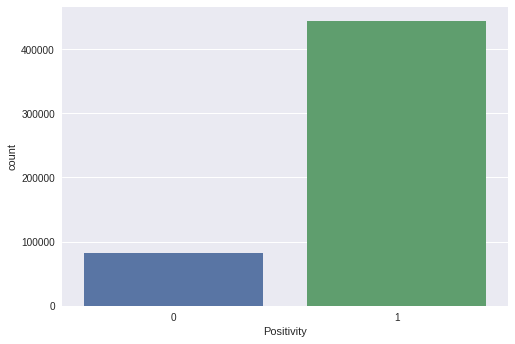

In [12]:
sns.countplot(review['Positivity'])
plt.show()

# Memory usage

In [13]:
review.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525773 entries, 0 to 568453
Data columns (total 11 columns):
Id                        525773 non-null int64
ProductId                 525773 non-null object
UserId                    525773 non-null object
ProfileName               525773 non-null object
HelpfulnessNumerator      525773 non-null int64
HelpfulnessDenominator    525773 non-null int64
Score                     525773 non-null int64
Time                      525773 non-null int64
Summary                   525773 non-null object
Text                      525773 non-null object
Positivity                525773 non-null int64
dtypes: int64(6), object(5)
memory usage: 436.8 MB


# Low memory

For other applications we could have applied various techniques to reduce memory usage,
here we are going to just drop columns which we don't require

In [14]:
review = review.drop(['ProductId','UserId','ProfileName','Id','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary'], axis=1)

In [15]:
# checking the memory usage again
review.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525773 entries, 0 to 568453
Data columns (total 2 columns):
Text          525773 non-null object
Positivity    525773 non-null int64
dtypes: int64(1), object(1)
memory usage: 271.9 MB


In [16]:
# split the data into training and testing data

# text will be used for training
# positivity is what we are predicting
X_train, X_test, y_train, y_test = train_test_split(review['Text'], review['Positivity'], random_state = 0)

In [17]:
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (394329,)


### Tokenization

In order to perform machine learning on text documents, we first need to turn these text content 
into numerical feature vectors that Scikit-Learn can use.

### Bag of words 
The simplest way to do so is to use [bags-of-words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/). First we convert the text document into a matrix of tokens. The default configuration tokenizes the string, 
by extracting words of at least 2 letters or numbers, separated by word boundaries, converts everything to lowercase 
and builds a vocabulary using these tokens

In [18]:
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
# checking the features
feat = vect.get_feature_names()

In [20]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(feat))

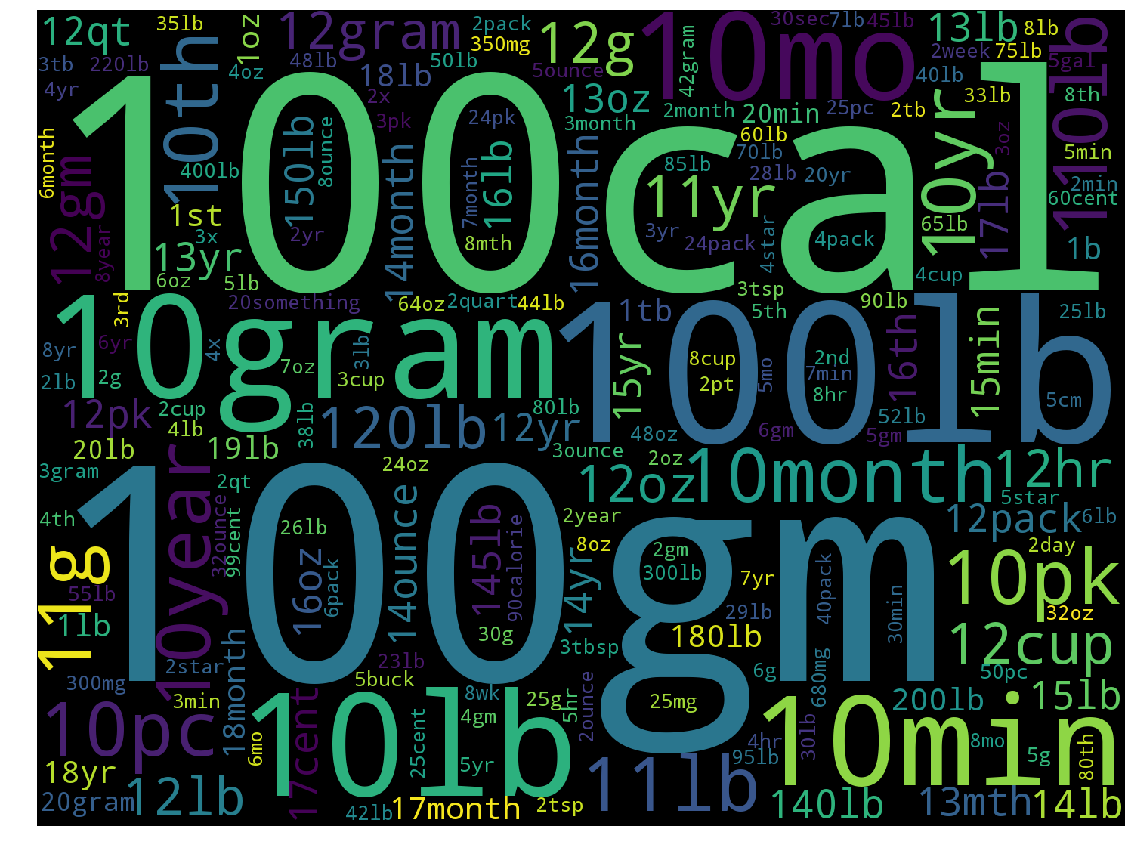

In [21]:
# larger the size of the word, more the times it appears
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [22]:
# checking the length of features
len(vect.get_feature_names())

102135

# Sparse matrix
We now transform the document into a bag-of-words representation i.e matrix form.
The result is stored in a sparse matrix i.e it has very few non zero elements.

Rows represent the words in the document while columns represent the words in our training vocabulary.

In [23]:
X_train_vectorized = vect.transform(X_train)

# the interpretation of the columns can be retreived as follows
# X_train_vectorized.toarray()

In [24]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# area under curve
predictions = model.predict(vect.transform(X_test))
roc_auc = roc_auc_score(y_test, predictions)
print('AUC: ', roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

AUC:  0.87393969092


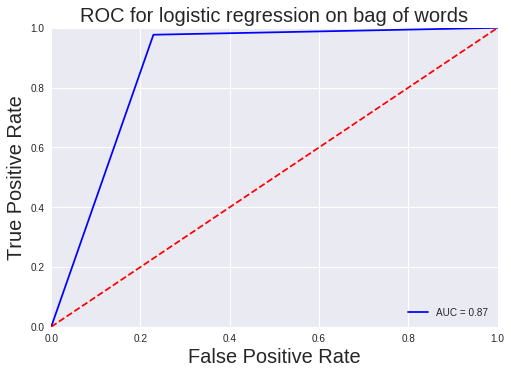

In [26]:
plt.title('ROC for logistic regression on bag of words', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.show()

In [27]:
# coefficient determines the weight of a word (positivity or negativity)
# checking the top 10 positive and negative words

# getting the feature names
feature_names = np.array(vect.get_feature_names())

# argsort: Integer indicies that would sort the index if used as an indexer
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['deceptive' 'worst' 'redeeming' '280mg' 'disappointing' 'unacceptable'
 'dissapointing' 'allegro' 'disappointment' 'undrinkable']

Largest Coefs: 
['emeraldforest' 'pleasantly' 'martini' 'skeptical' 'hooked' 'chedder'
 'incurred' 'addicting' 'jimmies' 'easiest']



# TF IDF (term-frequency-inverse-document-frequency).

This means that we weigh the terms by how uncommon they are, meaning that we care more about rare words than common ones.

### Why use TF IDF over bag of words?

In large texts, some words may be repeated often but will carry very little meaningful information about the actual
contents of the document. If we were to feed the count data directly to a classifier those very frequent terms would 
shadow the frequencies of rarer yet more interesting terms.

#### Tf-idf allows us to weight terms based on how important they are to a document.

In [28]:
# ignore terms that appear in less than 5 documents
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

35289

In [29]:
# check the top 10 features for positive and negative
# reviews again, the AUC has improved
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

IndexError: index 100554 is out of bounds for axis 1 with size 35289

In [30]:
feat = vect.get_feature_names()

In [31]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(feat))

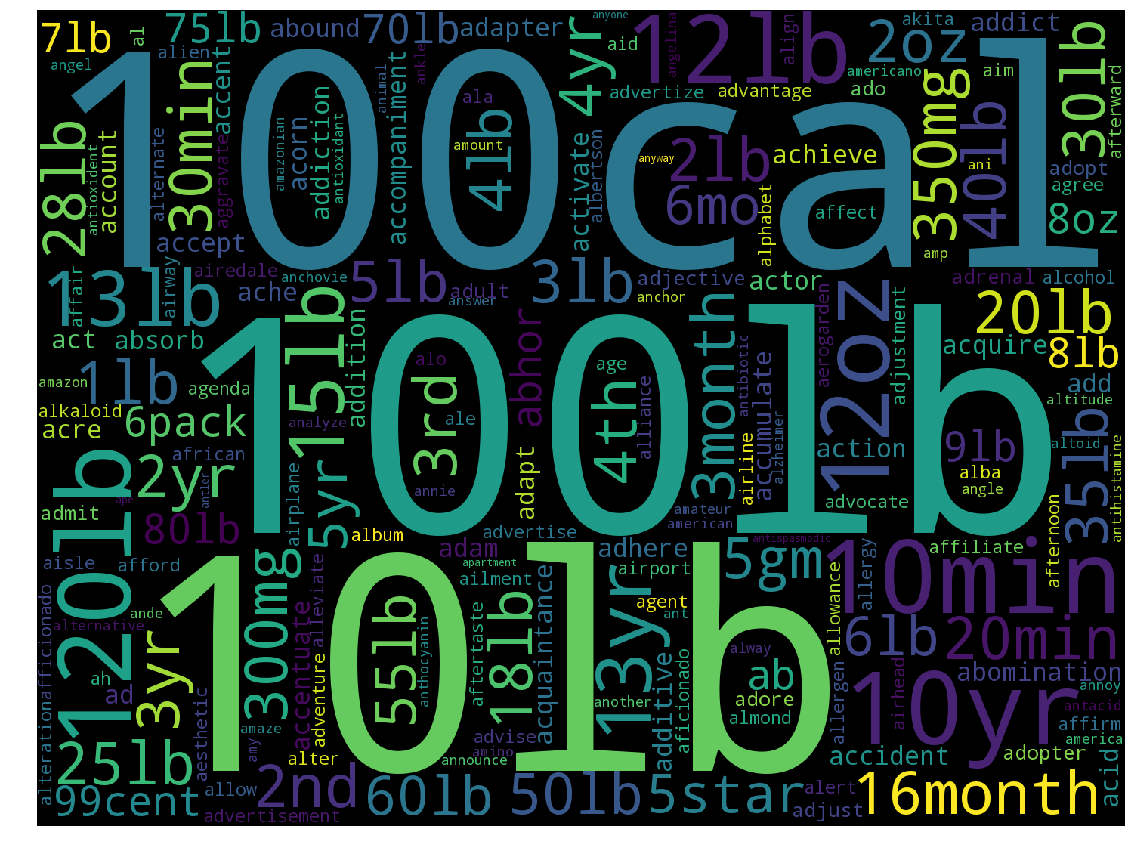

In [32]:
# larger the size of the word, more the times it appears
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [33]:
X_train_vectorized = vect.transform(X_train)

In [34]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
predictions = model.predict(vect.transform(X_test))
roc_auc = roc_auc_score(y_test, predictions)
print('AUC: ', roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

AUC:  0.85138328931


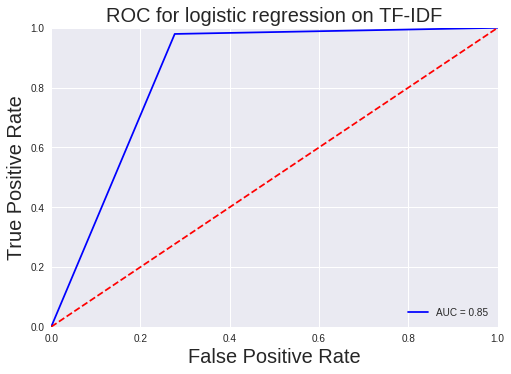

In [36]:
plt.title('ROC for logistic regression on TF-IDF', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.show()

In [37]:
# even though we reduced the number of features considerably
# the AUC did not change much

# let us test our model
new_review = ['The food was delicious', 'The food was not good']

print(model.predict(vect.transform(new_review)))

[1 1]


# Bigrams

Since our classifier misclassifies things like 'not good', we will use groups of words instead of single words.
This method is called n grams (bigrams for 2 words and so on). Here we take 1 and 2 words into consideration.

In [38]:
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

KeyboardInterrupt: 

In [ ]:
feat = vect.get_feature_names()

In [ ]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(feat))

In [ ]:
# larger the size of the word, more the times it appears
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
# the number of features has increased again
# checking for the AUC
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

In [ ]:
predictions = model.predict(vect.transform(X_test))
roc_auc = roc_auc_score(y_test, predictions)
print('AUC: ', roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [ ]:
plt.title('ROC for logistic regression on Bigrams', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.show()

In [ ]:
# check the top 10 features for positive and negative
# reviews again, the AUC has improved
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

In [ ]:
new_review = ['The food is not good, I would never buy them again']
print(model.predict(vect.transform(new_review)))

In [ ]:
new_review = ['One would be disappointed by the food']
print(model.predict(vect.transform(new_review)))

In [ ]:
new_review = ['One would not be disappointed by the food']
print(model.predict(vect.transform(new_review)))

In [ ]:
new_review = ['I would feel sorry for anyone eating here']
print(model.predict(vect.transform(new_review)))

In [ ]:
new_review = ['They are bad at serving quality food']
print(model.predict(vect.transform(new_review)))

In [ ]:
# there are still more misclassifications
# lets try with 3 grams
vect = CountVectorizer(min_df = 5, ngram_range = (1,3)).fit(X_train)
# X_train_vectorized = vect.transform(X_train)
# len(vect.get_feature_names())

In [ ]:
# add reference last mein
# and try to see if 3 grams works on kaggle
# don't add word clouds
# only plot the roc curves